# Mixed Layer Budgets

Here we're looking at mixed layer budgets constructed multiple ways

***

In [1]:
from calendar import monthrange
from cartopy import crs, feature
from copy import deepcopy
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt, dates
import numpy as np
import os
import pandas as pd
import pyremap
from scipy.interpolate import interp1d
from tqdm import tqdm
import xarray as xr

plt.rcParams.update({'font.size': 14, 'axes.titlesize': 'medium'})

***

## Salinity budgets

### Volume integrated mixed-layer budget

Start by integrating the salinity transport equation over the mixed layer control volume (with mixed layer depth $h$)

$$\int_V\left[\frac{\partial S}{\partial t} + \nabla\cdot\left(\vec{\mathbf{v}}S\right) + \nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)\right]dV = 0$$

(1) $\partial/\partial t$ term (Reynolds Transport Theorem)

$$\int_V\frac{\partial S}{\partial t}dV = \frac{d}{dt}\int_VSdV + \int_Aw_rS\big|_{-h}dA, \hspace{1.5cm} \text{where} \hspace{0.3cm} w_r = -\frac{dh}{dt}$$

(2) Advection term (Gauss's Theorem)

$$\int_V\nabla\cdot\left(\vec{\mathbf{v}}S\right)dV = \int_{\partial V}S\vec{\mathbf{v}}_H\cdot\hat{\mathbf{n}}_HdA - \int_A\left(S\vec{\mathbf{v}}_H\cdot\nabla h\right)\Big|_{-h}dA - \int_A\left(wS\right)\Big|_{-h}dA$$

(3) Diffusion term (Fundamental Theorem)

$$
\begin{align}
\int_V\nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)dV & = \int_V\nabla_H\cdot\left(\overline{\vec{\mathbf{v}}_H'S'}\right)dV + \int_V\frac{\partial}{\partial z}\left(\overline{w'S'}\right)dV\\[12pt]&= \int_V\nabla_H\cdot\left(\overline{\vec{\mathbf{v}}_H'S'}\right)dV + \int_A\overline{w'S'}\Big|_{-h}^0dA\\[12pt]&= \left(\int_V\nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)dV - \int_A\overline{w'S'}\Big|_0dA\right) + \int_A\overline{w'S'}\Big|_0dA
\end{align}
$$

**(1) Budget using tendency terms** (most straight-forward calculation)

$$\boxed{\vphantom{\rule{0pt}{22pt}}\hspace{12pt}\underbrace{\frac{d}{dt}\int_VSdV}_{\textbf{Residual}} = -\underbrace{\int_Aw_rS\big|_{-h}dA}_{\textbf{Entrainment}} - \underbrace{\int_V\nabla\cdot\left(\vec{\mathbf{v}}S\right)dV}_{\textbf{Advection}} - \underbrace{\int_V\nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)dV}_{\textbf{Mix+Nonloc+Surf+Fraz}}\hspace{12pt}}$$

**(2) Budget with mixing rearranged** (to separate surface and bottom fluxes)

$$\boxed{\vphantom{\rule{0pt}{22pt}}\hspace{12pt}\underbrace{\frac{d}{dt}\int_VSdV}_{\textbf{Residual}} = -\underbrace{\int_Aw_rS\big|_{-h}dA}_{\textbf{Entrainment}} - \underbrace{\int_V\nabla\cdot\left(\vec{\mathbf{v}}S\right)dV}_{\textbf{Advection}} - \underbrace{\left(\int_V\nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)dV - \int_A\overline{w'S'}\Big|_0dA\right)}_{\textbf{Mix+Nonloc+Surf+Fraz}-\textbf{TopFlux}} - \underbrace{\int_A\overline{w'S'}\Big|_0dA}_{\textbf{TopFlux}}\hspace{12pt}}$$

**(3) Budget using edge fluxes** (to allow for mean-eddy decomposition)

$$\boxed{\vphantom{\rule{0pt}{22pt}}\hspace{12pt}\underbrace{\frac{d}{dt}\int_VSdV}_{\textbf{Residual}} = \underbrace{\int_A\big(w\big|_{-h}-w_r\big)S\big|_{-h}dA}_{\textbf{Vert Adv + Entrainment}} - \underbrace{\int_{\partial V}S\vec{\mathbf{v}}_H\cdot\hat{\mathbf{n}}_HdA + \int_A\left(S\vec{\mathbf{v}}_H\cdot\nabla h\right)\Big|_{-h}dA}_{\textbf{Horizontal Advection}} - \underbrace{\int_V\nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)dV}_{\textbf{Mix+Nonloc+Surf+Fraz}}\hspace{12pt}}$$

### Volume averaged mixed layer budget

The problem with the volume-integrated budget, is that the mixed layer volume changes dominate the balance (i.e., entrainment outweighs advection and mixing). We can build a volume-averaged budget instead, by expanding the LHS with the mixed layer depth $h$ using the Product Rule

$$\frac{d}{dt}\int_VSdV = \int_A\left[\frac{d}{dt}\frac{h}{h}\int_{-h}^0Sdz\right]dA = \int_A\left[h\frac{d\overline{S}}{dt} - \overline{S}w_r\right]dA$$

where

$$\overline{S}=\frac{1}{h}\int_{-h}^0Sdz \hspace{0.3cm} \text{and} \hspace{0.3cm} \Delta S = S\big|_{-h} - \overline{S}$$

**Budget (1) becomes**

$$\boxed{\hspace{12pt}\underbrace{\frac{1}{A}\int_A\frac{d\overline{S}}{dt}dA}_{\textbf{Residual}} = -\frac{1}{A}\int_A\frac{1}{h}\left[\underbrace{w_r\Delta S}_{\textbf{Entrainment}} + \underbrace{\int_{-h}^0\nabla\cdot\left(\vec{\mathbf{v}}S\right)dz}_{\textbf{Advection}} + \underbrace{\int_{-h}^0\nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)dz}_{\textbf{Mix+Nonloc+Surf+Fraz}}\right]dA\hspace{12pt}}$$

**Budget (2) becomes**

$$\boxed{\hspace{12pt}\underbrace{\frac{1}{A}\int_A\frac{d\overline{S}}{dt}dA}_{\textbf{Residual}} = -\frac{1}{A}\int_A\frac{1}{h}\left[\underbrace{w_r\Delta S}_{\textbf{Entrainment}} + \underbrace{\int_{-h}^0\nabla\cdot\left(\vec{\mathbf{v}}S\right)dz}_{\textbf{Advection}} + \underbrace{\left(\int_{-h}^0\nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)dz - \overline{w'S'}\Big|_0\right)}_{\textbf{Mix+Nonloc+Surf+Fraz}-\textbf{TopFlux}} + \underbrace{\overline{w'S'}\Big|_0}_{\textbf{TopFlux}}\right]dA\hspace{12pt}}$$

**Budget (3) becomes**

(Scaled by $V$ instead of $A$ because the $h$ doesn't pass through cleanly)

$$\boxed{\hspace{12pt}\underbrace{\frac{1}{V}\int_Ah\frac{d\overline{S}}{dt}dA}_{\textbf{Residual}} = \frac{1}{V}\int_A\left[\underbrace{\big(wS\big)\big|_{-h}}_{\textbf{Vert Adv}} - \underbrace{w_r\Delta S}_{\textbf{Entrainment}} + \underbrace{\left(S\vec{\mathbf{v}}_H\cdot\nabla h\right)\Big|_{-h}}_{\textbf{Horz Adv}} - \underbrace{\int_{-h}^0\nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)dz}_{\textbf{Mix+Nonloc+Surf+Fraz}}\right]dA - \underbrace{\frac{1}{V}\int_{\partial V}S\vec{\mathbf{v}}_H\cdot\hat{\mathbf{n}}_HdA}_{\textbf{Horz Adv}}\hspace{12pt}}$$

### Constant volume budget

If we just want to construct a budget over a fixed volume with a flat bottom, say the top 300~m, then all terms with $w_r$ and $\nabla h$ go to zero.

***

## Now the budget calculation

I'm using the volume averaged version of **Budget (2)**, for both a variable mixed layer volume and a constant volume for the top 300~m.

First we define some helper functions.

In [2]:
def interp(Y, X, Xi, maxLevel):
    """Interpolation wrapper
    """

    # Interpolate
    Yi = []
    for y, x, xi, maxlevel in zip(Y, X, Xi, maxLevel):
        valid = np.isfinite(x)
        try:
            yi = interp1d(x[valid], y[valid])(xi)
        except ValueError:
            yi = y[maxlevel]
        Yi.append(yi)
    
    return np.array(Yi)


def get_depth_avg(array, H):
    """
    """

    array_avg = np.nansum(array * H, axis=1) / np.nansum(H, axis=1)

    return array_avg


def get_area_avg(array, areaCell, add_dim=False):
    """
    """

    if add_dim:
        areaCell = areaCell[:, None]
    areaTotal = (areaCell * ~np.isnan(array)).sum(axis=0)
    array_avg = np.nansum(array * areaCell, axis=0) / areaTotal

    return array_avg

Next we specify which mesh to process.

In [3]:
# Mesh to process
meshName = 'HR'

Next we build the coordinates we need.

In [4]:
# Build results prefix
paths = {
    'LR': {
        'mesh': '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc',
        'mask': '/pscratch/sd/b/bmoorema/maskfiles/EC30to60E2r2_transformationbudgetmasks20240724.nc',
        'map': '/global/cfs/cdirs/m4259/mapping_files/map_EC30to60E2r2_to_0.1x0.1degree_bilinear.nc',
        'results': '/pscratch/sd/b/bmoorema/run_001_062/20210421_sim7_CORE_60to30E2r2.mpaso.hist.am',
    },
    'HR': {
        'mesh': '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/oRRS18to6v3/oRRS18to6v3.171116.nc',
        'mask': '/pscratch/sd/b/bmoorema/maskfiles/oRRS18to6v3_transformationbudgetmasks20240724.nc',
        'map': '/global/cfs/cdirs/m4259/mapping_files/map_oRRS18to6v3_to_0.1x0.1degree_bilinear.nc',
        'results': '/global/cfs/cdirs/m4259/lvroekel/run_001_010/20210421_sim7_CORE_18to6v3.mpaso.hist.am',
    }
}
k300 = {'LR': 26, 'HR': 31}
bbox = [-69, -45, 52, 67]

# Load mask
ds = xr.open_dataset(paths[meshName]['mask'])
idx = ds.regionNames.astype(str) == 'Labrador Sea'
regionMask, = np.where(ds.regionCellMasks[:, idx][:, 0].values.astype(bool))

# Load mesh
ds = xr.open_dataset(paths[meshName]['mesh'])
nVertLevels = ds.nVertLevels.values
maxLevel = ds.maxLevelCell.values[regionMask] - 1
areaCell = ds.areaCell.values[regionMask]
depth = np.hstack([0, ds.refBottomDepth.values])
depth = (depth[:-1] + depth[1:]) / 2
regionMask3D = nVertLevels <= maxLevel[:, None]

# Build remapper
dafull = xr.DataArray(np.zeros(ds.sizes['nCells']), dims='nCells')
meshLongName = os.path.split(os.path.split(paths[meshName]['mesh'])[0])[1]
inDescriptor = pyremap.MpasMeshDescriptor(paths[meshName]['mesh'], meshLongName)
outDescriptor = pyremap.get_lat_lon_descriptor(dLon=0.1, dLat=0.1)
remapper = pyremap.Remapper(inDescriptor, outDescriptor, paths[meshName]['map'])

# Get LR depth for interpolation
if meshName == 'HR':
    ds = xr.open_dataset(paths['LR']['mesh'])
    depthLR = np.hstack([0, ds.refBottomDepth.values])
    depthLR = (depthLR[:-1] + depthLR[1:]) / 2

# Package into coords dict
coords = {
    'regionMask'   : regionMask,
    'regionMask3D' : regionMask3D,
    'areaCell'     : areaCell,
    'maxLevel'     : maxLevel,
    'depth'        : depth,
    'k300'         : k300[meshName],
    'remapper'     : remapper,
    'dafull'       : dafull,
    'bbox'         : bbox,
}

# Variable names
prefix = 'timeMonthly_avg_'
varNames = {
    'MLD': ['dThreshMLD'],
    'H'  : ['layerThickness'],
    'S'  : ['activeTracers_salinity'],
    'rho': ['potentialDensity'],
    'Adv': [
        'activeTracerHorizontalAdvectionTendency_salinityHorizontalAdvectionTendency',
        'activeTracerVerticalAdvectionTendency_salinityVerticalAdvectionTendency',
    ],
    'Mix': [
        'activeTracerHorMixTendency_salinityHorMixTendency',
        'activeTracerVertMixTendency_salinityVertMixTendency',
        'activeTracerNonLocalTendency_salinityNonLocalTendency',
        'activeTracerSurfaceFluxTendency_salinitySurfaceFluxTendency',
    ],
    'Surf_S'   : ['salinitySurfaceRestoringTendency'],
    'Surf_salt': ['seaIceSalinityFlux'],
    'Surf_fw'  : [
        'evaporationFlux',
        'rainFlux',
        'snowFlux',
        'riverRunoffFlux',
        'iceRunoffFlux',
        'seaIceFreshWaterFlux',
    ],
}

# Constants
rho_fw = 1e3
salt_to_S = 1e3 / 1026

Next we do the processing for all month.

In [5]:
# Variable names
standardNames = ['tLF', 'tHF', 'MLDLF', 'MLDHF', 'S1D', 'rho1D']
budgetNames = ['S', 'Adv', 'Mix', 'Ent', 'Surf']

# Build outputs dict
outputs = {name: [] for name in standardNames}
outputs.update({name: [] for name in budgetNames})
outputs.update({f'{name}2D': [] for name in ['Adv', 'Mix', 'Surf']})

# Loop through monthly files
for year in range(1, 11):
    for month in tqdm(range(1, 13), desc=f'Loading {year}'):

        variables = {}

        # Get entrainment velocity
        ds = xr.open_dataset(f"{paths[meshName]['results']}.highFrequencyOutput.{year:04d}-{month:02d}-01_00.00.00.nc")
        t = np.array([parse(dt.split('_')[0]) for dt in ds.xtime.astype(str).values])
        MLD = ds.dThreshMLD.values[:, coords['regionMask']]
        w_r = -np.mean(np.diff(MLD, axis=0), axis=0) / 432000
        outputs['tHF'].append(t)
        outputs['MLDHF'].append(get_area_avg(MLD.T, coords['areaCell'], add_dim=True))
        
        # Get remaining variables
        ds = xr.open_dataset(f"{paths[meshName]['results']}.timeSeriesStatsMonthly.{year:04d}-{month:02d}-01.nc")
        start, end = [parse(ds[f'xtime_{name}Monthly'].astype(str).values[0].split('_')[0]) for name in ('start', 'end')]
        t = start + timedelta(days=int((end - start).days / 2))
        for varName, names in varNames.items():
            variables[varName] = sum([ds[f'{prefix}{name}'][0].values[coords['regionMask']] for name in names])
            if variables[varName].ndim > 1:
                variables[varName][~coords['regionMask3D']] = np.nan
            if varName == 'rho':
                variables[varName] = variables[varName] - 1000
        
        # Calculate depths
        zeros = np.zeros((len(coords['regionMask']), 1))
        interface = np.hstack([zeros, np.cumsum(variables['H'], axis=1)])
        midpoint = (interface[:, :-1] + interface[:, 1:]) / 2

        # Get 3D fields
        outputs['tLF'].append(t)
        outputs['MLDLF'].append(get_area_avg(variables['MLD'], coords['areaCell']))
        for name in ['S', 'rho']:
            variable = get_area_avg(variables[name], coords['areaCell'], add_dim=True)
            if meshName == 'HR':
                variable = interp1d(coords['depth'], variable)(depthLR)
            outputs[f'{name}1D'].append(variable)

        # Get total surface flux
        fw_to_S = -variables['S'][:, 0] / rho_fw
        Surf = variables['Surf_S'] + salt_to_S * variables['Surf_salt'] + fw_to_S * variables['Surf_fw']
        Surf = Surf / variables['MLD']

        # Get vertical averages
        for avgtype in ['ML', '300']:

            # Get vertical average
            if avgtype == 'ML':
                slc = slice(None, None)
                mask = np.clip((variables['MLD'][:, None] - interface[:, :-1]) / variables['H'], 0, 1)
                H = variables['H'] * mask
            else:
                slc = slice(None, coords['k300'])
                H = variables['H'][:, slc]
            S, Adv, Mix = [get_depth_avg(variables[name][:, slc], H) for name in ('S', 'Adv', 'Mix')]
            Mix = Mix - Surf
    
            # Get entrainment
            if avgtype == 'ML':
                S_bot = interp(variables['S'], midpoint, variables['MLD'], coords['maxLevel'])
                Ent = (S - S_bot) / variables['MLD'] * w_r
            else:
                Ent = 0
    
            # Area-avg ML variables
            for name, var in zip(budgetNames, [S, Adv, Mix, Ent, Surf]):

                # Convert tendencies to d-1
                if name != 'S':
                    var = var * 86400

                # Remap 2D field and append to list
                if month == 6:
                    if name in ['Adv', 'Mix', 'Surf']:
                        var2D = deepcopy(coords['dafull'])
                        var2D.loc[coords['regionMask']] = var
                        var2D = coords['remapper'].remap(var2D)
                        var2D = var2D.sel(lon=slice(*bbox[:2]), lat=slice(*bbox[2:]))
                        if 'lon' not in coords or 'lat' not in coords:
                            coords['lon'] = var2D.lon.values
                            coords['lat'] = var2D.lat.values
                        outputs[f'{name}2D'].append(var2D.values)

                # Get area-average and append to list
                var = get_area_avg(var, coords['areaCell'])
                outputs[name].append(var)

/tmp/ipykernel_1955924/1507381647.py:34: RuntimeWarning: invalid value encountered in divide
  array_avg = np.nansum(array * areaCell, axis=0) / areaTotal
Loading 10: 100%|██████████| 12/12 [04:31<00:00, 22.63s/it]


Finally, we concatenate the fields and save to netCDF.

In [7]:
# Get coords
startyear = relativedelta(years=1947)
coords = {
    'tHF': np.hstack(outputs['tHF']) + startyear,
    'tLF': np.hstack(outputs['tLF']) + startyear,
    'lon': coords['lon'],
    'lat': coords['lat'],
    'depth': depthLR,
    'avgtype': ['ML', '200'],
}
coords['tYR'] = coords['tLF'][5::12]

# Get MLD
variables = {}
variables['MLDHF'] = ('tHF', np.hstack(outputs['MLDHF']))
variables['MLDLF'] = ('tLF', np.hstack(outputs['MLDLF']))

# Get 1D variables
dims = ['tLF', 'depth']
for name in ['S1D', 'rho1D']:
    variables[name] = (dims, np.vstack(outputs[name]))

# Get budget variables
dims = ['avgtype', 'tLF']
days = np.array([dt.toordinal() for dt in coords['tLF']])
for name in budgetNames:
    variable = np.vstack([outputs[name][::2], outputs[name][1::2]])
    variables[name] = (dims, variable)
variables['dSdt'] = (dims, np.gradient(variables['S'][1], days, axis=1))
variables['Res'] = (dims, sum([variables[name][1] for name in budgetNames[1:]]))

# Get 2D budget variables
dims = ['avgtype', 'tYR', 'lat', 'lon']
for name in ['Adv2D', 'Mix2D', 'Surf2D']:
    variable = np.array([outputs[name][::2], outputs[name][1::2]])
    variables[name] = (dims, variable)

ds = xr.Dataset(variables, coords)
ds.to_netcdf(f'/pscratch/sd/b/bmoorema/results/budgets/budget_variables_{meshName}.nc')

***

## Visualization

Load preprocessed datasets and estimate salinity from residual.

In [2]:
ds = {meshName: xr.open_dataset(f'/pscratch/sd/b/bmoorema/results/budgets/budget_variables_{meshName}.nc') for meshName in ['LR', 'HR']}

In [3]:
# Days for forward integration
days = np.array([monthrange(2010, month)[1] for year in range(10) for month in range(1, 13)])
for meshName, S0 in zip(ds, [(33.8, 34.1), (33.5, 34)]):
    values = np.cumsum(np.vstack([S0, ds[meshName]['Res'].values.T * days[:, None]])[:-1, :], axis=0).T
    ds[meshName]['S_res'] = (['avgtype', 'tLF'], values)

Generic plotting function for budget terms

In [4]:
def plot_budget_terms(ax, ds, varNames, palette, xlim, ylim, legend=True, diff=False):
    """
    """

    # Plot budget terms
    ax.plot(xlim, [0, 0], 'k--')
    for name, color in zip(varNames, palette):
        if diff:
            label = name if legend else None
            ax.plot(ds['LR'].tLF, ds['HR'][name][0, :]-ds['LR'][name][0, :], ls='-', color=color, label=label)
        else:
            for meshName, ls in zip(['HR', 'LR'], ['-', ':']):
                label = name if legend and meshName == 'HR' else None
                ax.plot(ds[meshName].tLF, ds[meshName][name][0, :], ls=ls, color=color, label=label)
    if diff:
        ax.plot(-100, -100, 'k-', label='HR$-$LR')
    else:
        for meshName, ls in zip(['HR', 'LR'], ['-', ':']):
            ax.plot(-100, -100, 'k', ls=ls, label=meshName)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel('[ppt/d]')
    ax.grid(ls=':')
    ax.legend(loc=1)

### Time evolution of budget terms

Here we look at the region-averaged budget terms over the first 7 years of simulation.

Text(0.005, 0.92, '(c)')

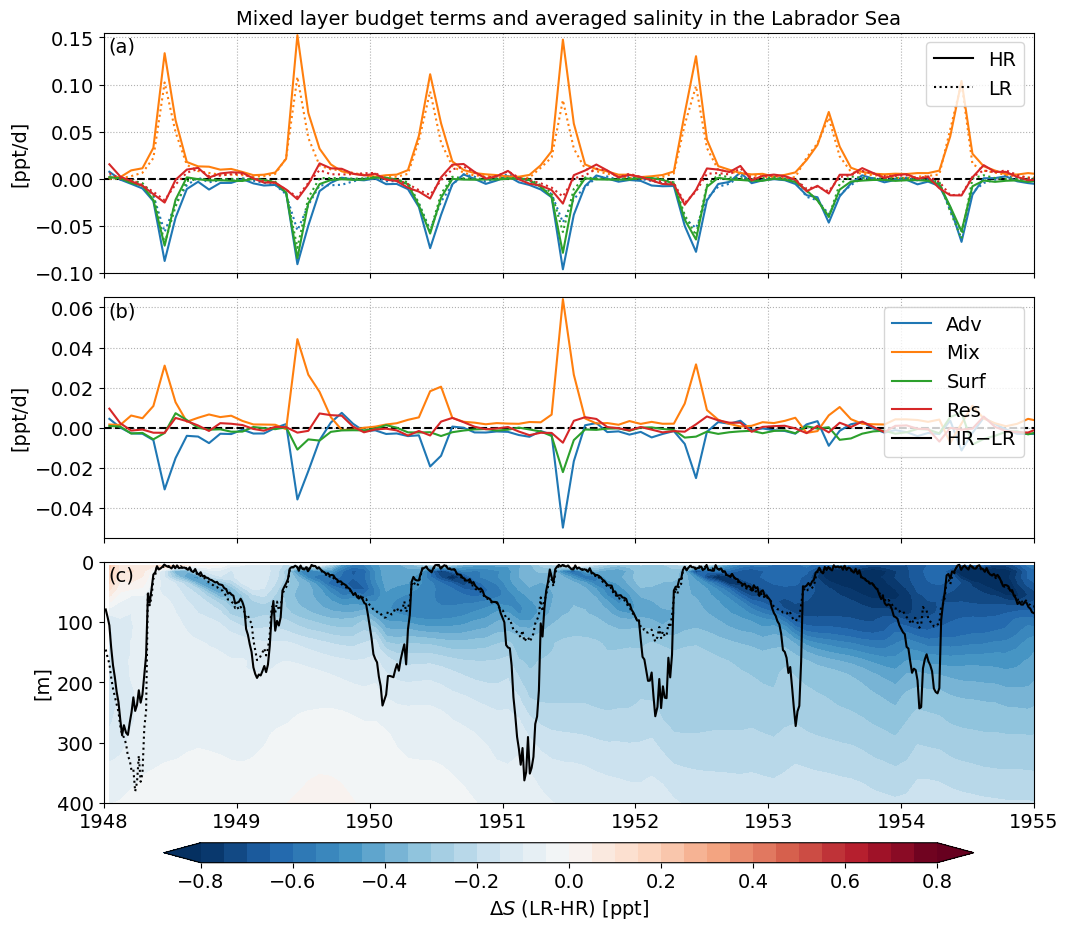

In [5]:
# Make figure
fig, axs = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'hspace': 0.1})
xlim = [datetime(1948, 1, 1), datetime(1955, 1, 1)]
palette = plt.get_cmap('tab10').colors
names = ['Adv', 'Mix', 'Surf', 'Res']

# Top
plot_budget_terms(axs[0], ds, names, palette, xlim, [-0.1, 0.155], legend=False)
axs[0].set_title('Mixed layer budget terms and averaged salinity in the Labrador Sea')
axs[0].xaxis.set_ticklabels('')
axs[0].text(0.005, 0.92, '(a)', transform=axs[0].transAxes)

# Middle
plot_budget_terms(axs[1], ds, names, palette, xlim, [-0.055, 0.065], diff=True)
axs[1].xaxis.set_ticklabels('')
axs[1].text(0.005, 0.92, '(b)', transform=axs[1].transAxes)

# Bottom
ax = axs[2]
xyz = ds['LR'].tLF, ds['LR'].depth, (ds['LR'].S1D - ds['HR'].S1D).T
c = ax.contourf(*xyz, levels=np.arange(-0.8, 0.81, 0.05), extend='both', cmap='RdBu_r')
for meshName, ls in zip(ds, [':', '-']):
    ax.plot(ds[meshName].tHF, ds[meshName].MLDHF, 'k', ls=ls)
ax.set_ylim(400, 0)
ax.set_ylabel('[m]')
pos = ax.get_position()
cax = fig.add_axes([pos.x0+0.05, 0.05, pos.width-0.1, 0.02])
fig.colorbar(c, cax=cax, orientation='horizontal', label='$\\Delta S$ (LR-HR) [ppt]')
ax.set_xlim(xlim)
axs[2].text(0.005, 0.92, '(c)', transform=axs[2].transAxes)

**(a) Top Panel**
   - Seasonal cycle of the 3 dominant budget terms (**Adv**, **Mix**, **Surf**), peaking in summer.
   - **Adv** and **Surf** are always negative (freshening) and **Mix** is always positive (salinification).
   - The 3 terms largely balance to a small **Res**, which is negative (freshening) in summer and positive (salinification) in fall.
   - **HR** has stronger **Adv** (freshening) and **Mix** (salinification) than **LR**, but hard to discern other differences from this plot.

**(b) Middle Panel**
   - The differences between **HR** and **LR** largely compensate. That is, in **HR** stronger **Adv** (freshening) is accompanied by stronger **Mix** (salinification).
   - Although these differences compensate in terms of **Res**, they still would ultimately lead to greater freshwater exchange across the mixed layer.
   - **Res** does differ between the simulations: more salinification at **HR** which ultimately prevents mixed layer freshening over time.
   - There are differences in **Surf** between the 2 simulations, which is probably due to differences in sea ice.

**(c) Bottom Panel**
   - The freshening signal in **LR** begins during the first summer along the base of the mixed layer.
   - This pattern continues and intensifies in subsequent summers.
   - **LR** deep convection appears to be significantly affected beginning in the third winter (1950).

**High-level summary**
   - Summer mixed layer exchanges appear to drive the **LR** freshening.
   - Even though these exchanges largely balance to a small **Res**, the larger compensating **Adv** and **Mix** exchanges in **HR** suggest more vertical freshwater connectivity than **LR**.
   - The location of the **LR** freshening signal along the base of the mixed layer further supports this interpretation.
   - Changes in deep convection here are a *result* of the freshening, not a *cause*.

### Spatial fields of budget terms

We know that **Adv** and **Mix** are larger in **HR**, but we need more information. Here we look at the mixed layer averages of **Adv**, **Mix**, and **Surf** spatially over the Labrador Sea during the first June.

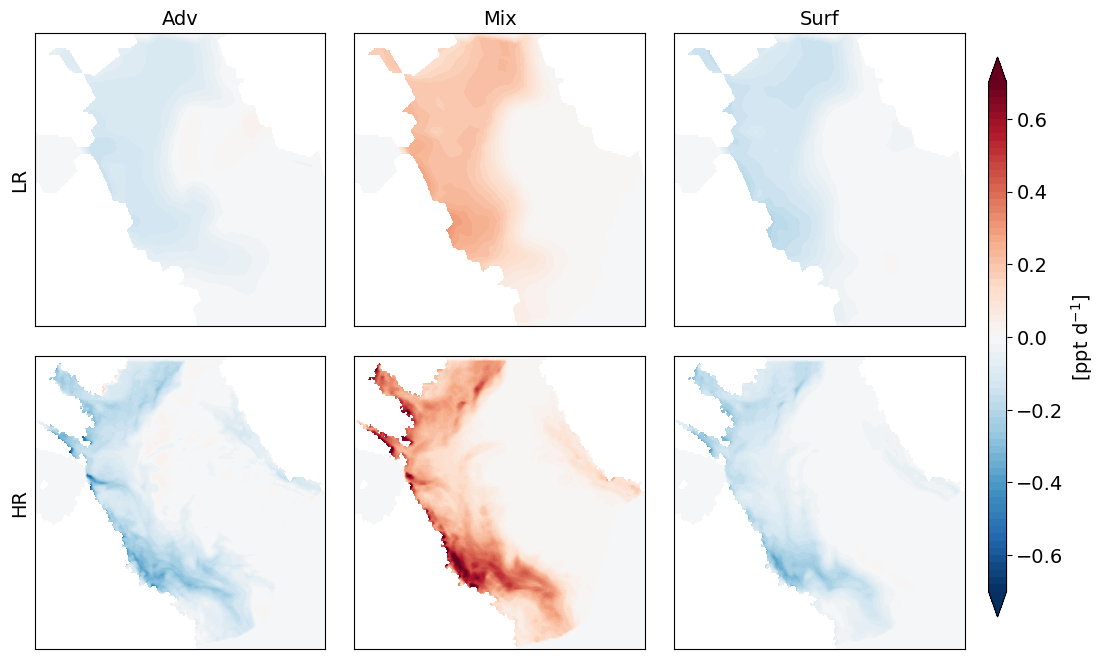

In [6]:
# Make figure
fig, axs = plt.subplots(2, 3, figsize=(12, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
names = ['Adv', 'Mix', 'Surf']
for row, meshName in zip(axs, ['LR', 'HR']):
    row[0].set_ylabel(meshName)
    for ax, name in zip(row, names):
        da = ds[meshName][f'{name}2D'][0, 0]
        c = ax.contourf(da.lon, da.lat, da, np.arange(-0.7, 0.71, 0.02), cmap='RdBu_r', extend='both')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        if meshName == 'LR':
            ax.set_title(name)
cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(c, cax=cax, label='[ppt d$^{-1}$]', ticks=np.arange(-0.6, 0.61, 0.2))

**High-level summary**
   - The region-averaged peaks are apparent here as broadly-distributed over the western Labrador Sea.
   - The spatial extent is similar between **LR** and **HR**, but **HR** has finer structure and the fields are larger amplitude (except **Surf**).
   - We can now generally conclude that **Adv** freshening and **Mix** salinification are larger in **HR**, but we still need more context to understand why.

***

## Box Model

We want to check the freshening and salinification roles of **Adv** and **Mix** against simple mass and volume conservation. We can do this with a simple mixed layer box model.

First a few helper functions.

In [7]:
def boxmodel_diagram():
    """Build boxmodel diagram
    """

    # Make figure
    fig = plt.figure(figsize=(10, 3))
    gs = plt.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[4, 1], wspace=0.5, hspace=0)
    ax_left = fig.add_subplot(gs[0, 0])
    ax_right = fig.add_subplot(gs[:, 1])

    # Left panel diagram
    ax_left.set_xlim(0, 1)
    ax_left.set_ylim(0, 1)
    ax_left.xaxis.set_ticks([])
    ax_left.yaxis.set_ticks([])
    arrows = [
        [0.5,  1.1,  0.0, -0.2, 0.03, 0.10],
        [0.3, -0.1,  0.0,  0.2, 0.03, 0.10],
        [0.7, -0.1,  0.0,  0.2, 0.03, 0.10],
        [0.1,  0.5, -0.2,  0.0, 0.05, 0.05],
        [0.9,  0.5,  0.2,  0.0, 0.05, 0.05],
    ]
    labels = [
        [0.50,  1.2, '$-QS_0L$'],
        [0.30, -0.2, '$wS_bL$'],
        [0.70, -0.2, '$\\kappa L(S_b-S_0)/H$'],
        [0.85,  0.6, '$vH(S_b+S_0)/2$'],
        [0.50,  0.5, '$d\\overline{S}/dt$'],
    ]
    for arrow, label in zip(arrows, labels):
        ax_left.arrow(*arrow[:4], width=arrow[4], head_length=arrow[5], fc='k', clip_on=False)
        ax_left.text(*label, ha='center', va='center', transform=ax_left.transAxes)

    # Right panel salinity profile
    ax_right.plot([0, 1], [0.8, 0.8], 'k--')
    ax_right.plot([0, 1], [0, 1], 'k-')
    ax_right.set_xlim(0, 1)
    ax_right.set_ylim(1, 0)
    ax_right.xaxis.set_ticks([0, 0.8])
    ax_right.yaxis.set_ticks([0, 0.8])
    ax_right.xaxis.set_ticklabels(['$S_0$', '$S_b$'])
    ax_right.yaxis.set_ticklabels(['$0$', '$-H$'])
    ax_right.set_title('Salinity Profile')


def boxmodel_plot():
    """Plot dS/dt and kappa/H from box model
    """

    # Constants
    H = 10       # Mixed layer depth [m]
    kappa = 0.1 # Vertical diffusivity [m2 s-1]
    Q = 0.002    # Freshwater input  [m s-1]
    Sb = 35      # Bottom salinity   [ppt]
    
    # Variables
    w = np.linspace(-0.1, 0.1, 100)      # Vertical velocity [m s-1]
    DeltaS = np.linspace(0.1, 5, 100)      # Salinity difference [ppt]
    w, DeltaS = np.meshgrid(w, DeltaS)
    S0 = Sb - DeltaS
    
    # Expressions
    dSdt = ((w - Q + 2 * kappa / H) * DeltaS - 4 * Q * S0) / (2 * H)
    kH = (Q * (4 * S0 / DeltaS + 1) - w) / 2
    
    # Bundle into list of tuples
    variables = [
        (dSdt, (-0.03, 0.001, 0.001, 0.01), 'Blues_r', '$d\\overline{S}/dt$ [ppt s$^{-1}$]', 'min'),
        (kH, (0, 0.181, 0.005, 0.05), 'inferno', 'k/h [m s$^{-1}$]', 'max'),
    ]
    
    # Plot expression
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.15})
    for ax, var in zip(axs, variables):
        c = ax.contourf(w, DeltaS, var[0], levels=np.arange(*var[1][:3]), cmap=var[2], extend=var[4])
        ax.contour(w, DeltaS, var[0], levels=[0], colors='k')
        ax.set_xlim([-0.1, 0.1])
        ax.set_ylim(1, 5)
        ax.xaxis.set_ticks(np.arange(-0.1, 0.11, 0.05))
        ax.yaxis.set_ticks(range(1, 6, 1))
        ax.set_xlabel('$w$ [m s$^{-1}$]')
        ax.text(0.82, 0.85, 'Invalid', transform=ax.transAxes)
        pos = ax.get_position()
        cax = fig.add_axes([pos.x0, -0.1, pos.width, 0.03])
        fig.colorbar(c, cax=cax, orientation='horizontal', label=var[3], ticks=np.arange(*var[1][:2], var[1][3]))
    axs[0].set_ylabel('$\\Delta S$ [ppt]')
    axs[1].yaxis.set_ticklabels('')

***

### Box model budget

This budget considers horizontal and vertical advection, vertical mixing, and freshwater inputs through a simple mixed layer box. The salinity profile is linear for simplicity. All arrows are positive-in (positive $Q$ gives negative $d\overline{S}/dt$).

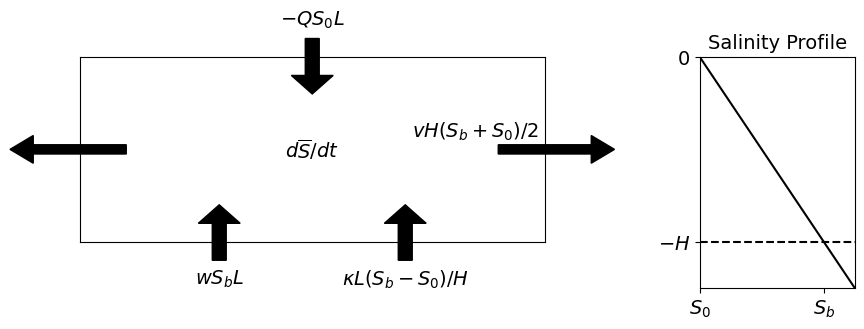

In [8]:
# Show box diagram
boxmodel_diagram()

**Step (1): Explain how advection always freshens the mixed layer**

If mass balance were only governed by advection, then upwelling would salinify the mixed layer because $S_b > (S_b + S_0) / 2$. But we observe that advection *always* freshens the mixed layer regardless of upwelling or downwelling. The reason for this is that the freshwater flux term $Q$ is always present, such that vertical advection is smaller than horizontal during upwelling and larger during downwelling. We demonstrate the importance of $Q$ by constructing the advective mass budget

$$LH\frac{d\overline{S}}{dt} = wS_bL + vH\frac{S_b + S_0}{2}$$

and volume conservation

$$vH = -\big(w + Q\big)L$$

Combine (where $\Delta S = S_b - S_0 > 0$)

$$\frac{d\overline{S}}{dt} = \frac{1}{2H}\bigg[\big(w - Q\big)\Delta S - 2QS_0\bigg]$$

Find $Q$ where $d\overline{S}/dt < 0$

$$\frac{w}{2S_0/\Delta S + 1} < Q$$

We can see that for $w > 0$, which would salinify the mixed layer in a closed box, we must have $Q > 0$ to compensate. As $\Delta S\to0$, $Q$ can be small, but as $\Delta S\to\infty$, $Q\to w$.

**Step (2): Explore connection between advection and mixing**

In both simulations, advective freshening and CVmix salinification of the mixed layer largely compensate, increasing and decreasing in phase. Here we look for an intrinsic connection between the two just from mass conservation. We demonstrate this by constructing the full mass budget

$$LH\frac{d\overline{S}}{dt} = wS_bL - QS_0L + vH\frac{S_b + S_0}{2} + \kappa L\frac{S_b - S_0}{H}$$

Combine with volume conservation

$$\frac{d\overline{S}}{dt} = \frac{1}{2H}\left[\left(w - Q + \frac{2\kappa}{H}\right)\Delta S - 4QS_0\right]$$

Find $\kappa/H$ where $d\overline{S}/dt < 0$

$$\frac{\kappa}{H} < \frac{1}{2}\left[Q\left(\frac{4S_0}{\Delta S} + 1\right) - w\right]$$

***

### Visualization

Plot $d\overline{S}/dt$ and the inequality $\kappa/H$ to see how they vary with $w$ and $\Delta S$.

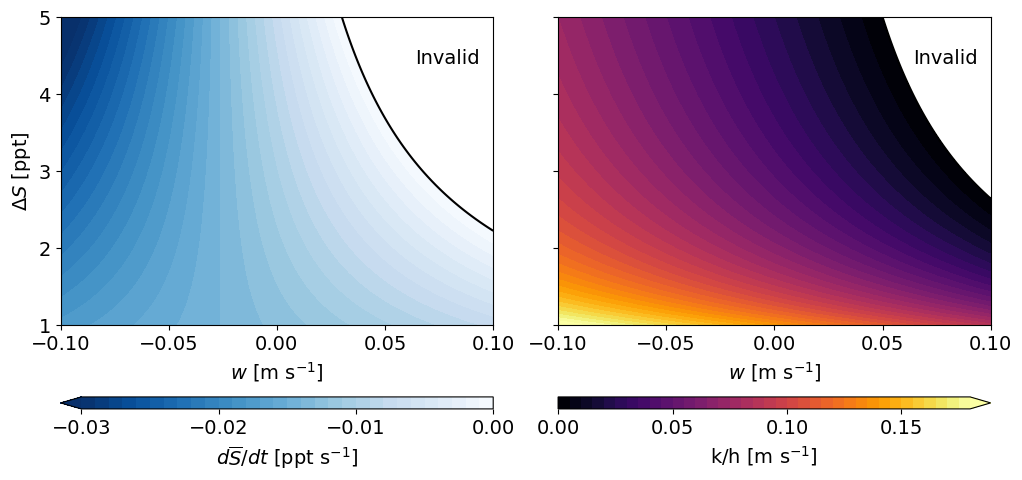

In [9]:
# Plot dS/dt and k/H
boxmodel_plot()

**High-level summary**
   - We can see that $d\overline{S}/dt$ becomes more negative with decreasing $w$, but we still have $d\overline{S}/dt<0$ for positive $w$.
   - We can see that $\kappa/H$ increases with decreasing $w$ in a similar trend. We can infer that, by mass balance alone, as $d\overline{S}/dt$ becomes more negative due to advection, $d\overline{S}/dt$ due to mixing will become more positive.
   - Most importantly, we can see that as stratification (e.g., $\Delta S$) increases, $d\overline{S}/dt$ becomes more negative and $\kappa/H$ decreases.

***

## Overview

**Overall takeway**
   1. The **LR** freshening in the Labrador Sea begins along the base of the mixed layer during the first summer
   2. **Adv** freshening and **Mix** salinification are weaker here in **LR** compared to **HR**
   3. These differences compensate in terms of **Res**, but they both act to *increase* freshwater throughput in the Lab Sea
   4. The fact that **Adv** is *always* freshening is explained by mass and volume conservation where freshwater input is present
      - Upwelling (salinification) is smaller than horizontal divergence (freshening)
      - Downwelling (freshening) is larger than horizontal convergence (salinification)
   5. The larger **Adv** and **Mix** in **HR** are consistent with stronger dynamics
      - Stronger circulation leads to more **Adv** and larger $\kappa$ at the base of the mixed layer